# UN Millennium Goals- Timeseries AR Model

Data: timeseries values for 241 countries, for 1337 indicators from 1970 - 2007; 737 prediction variables

Exploratory data analysis found (previous notebook):
- Countries range from 1 to 6 prediction variables
- Every series has some missing data
- Most data appears to have a linear or exponential trend over time
- Prediction variables may have strongest relationship with different metric from the previous year, e.g. "In Sierra Leone, the progress of 'Ensure environmental sustainability' is most correlated with a change in 'Gross national expenditure (constant LCU)' during the year before."


Data prep and initial modeling (this notebook): 
- subset rows for predictions only
- transpose data (cols with years only)
- correct index to date_time format
- remove NaNs
- test ARIMA iterations (for series 1 and 3, only AR was successful)

Next steps:
- Forecasting 
- Create alogrithm for all prediction variables


- Alternate model: 
    - split by country
    - cull to years all have data (remove na)
    - random forest
    - algorithm for all prediction variables


In [1]:
#trim this list!
import numpy as np
import pandas as pd
#from sklearn import cross_validation
#from sklearn import neighbors
#from sklearn import grid_search
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

from pandas.tools.plotting import autocorrelation_plot

In [2]:
# Load data
trainingdf = pd.read_csv("TrainingSet.csv", index_col=0) 

# Check head
trainingdf.head()

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.933105,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.996814,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection


In [3]:
submission_labels = pd.read_csv("SubmissionRows.csv", index_col=0)
submission_labels.head()

,2008 [YR2008],2012 [YR2012]
559,NaN,NaN
618,NaN,NaN
753,NaN,NaN
1030,NaN,NaN
1896,NaN,NaN


In [4]:
#to more easily reference year (from DataDriven)

def generate_year_list(start, stop=None):
    """ 
    make a list of column names for specific years
    in the format they appear in the data frame start/stop inclusive
    """
    
    if isinstance(start, list):
        data_range = start
    elif stop:
        data_range = range(start, stop+1)
    else:
        data_range = [start]
    
    yrs = []
    
    for yr in data_range:
        yrs.append("{0} [YR{0}]".format(yr))
        
    return yrs

In [5]:
#looking at just submission rows
prediction_rows = trainingdf.loc[submission_labels.index]
prediction_rows["Country Name"].value_counts()


Moldova                     6
Guinea                      6
Cuba                        6
Senegal                     5
Mongolia                    5
South Africa                5
Mauritania                  5
Azerbaijan                  5
Burkina Faso                5
Mexico                      5
Pakistan                    5
Mozambique                  5
Zambia                      5
Lesotho                     5
Kyrgyz Republic             5
Niger                       5
Colombia                    5
El Salvador                 5
Panama                      5
Belarus                     5
Chile                       5
Indonesia                   5
Mauritius                   5
Tunisia                     5
Sri Lanka                   5
Morocco                     5
Namibia                     5
Gambia, The                 5
Lao PDR                     5
Dominican Republic          5
                           ..
Aruba                       2
Austria                     2
Bahrain   

In [6]:
prediction_rows_yearsonly = prediction_rows[generate_year_list(1972, 2007)]
prediction_rows_yearsonly.head()

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],...,1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007]
559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.1520,0.1870,0.2210,0.256000,0.291000,0.325000,0.360000,0.395000,0.430000,0.4650
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000047,0.000046,0.000879,0.001058,0.012241,0.021071,0.0190
753,0.296,0.2909,0.2852,0.2798,0.2742,0.2683,0.2624,0.2565,0.2503,0.2439,...,0.1391,0.1366,0.1339,0.131000,0.127700,0.124400,0.121000,0.117700,0.114500,0.1115
1030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0010,0.0010,0.0010,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.0010
1896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.9650,0.9650,0.9650,0.964000,0.964000,0.963000,0.963000,0.962000,0.962000,0.9610


In [7]:
transposed = prediction_rows_yearsonly.transpose()
transposed.tail()

,559,618,753,1030,1896,1955,2090,2690,3233,3292,...,283137,283460,284003,284062,284197,284474,285340,285399,285534,285811
2003 [YR2003],0.325,0.000879,0.1244,0.001,0.963,0.009719,0.0245,0.939567,0.874,0.021954,...,0.001,NaN,0.557,0.009805,0.1433,0.144,0.796,0.063948,0.0985,0.213
2004 [YR2004],0.360,0.001058,0.1210,0.001,0.963,0.024204,0.0233,0.946588,0.866,0.046345,...,0.001,0.869995,0.566,0.020135,0.1349,0.141,0.796,0.065640,0.0973,0.198
2005 [YR2005],0.395,0.012241,0.1177,0.001,0.962,0.060439,0.0222,0.946235,0.859,0.058439,...,0.001,0.952192,0.575,0.028518,0.1270,0.138,0.797,0.080160,0.0966,0.184
2006 [YR2006],0.430,0.021071,0.1145,0.001,0.962,0.096100,0.0212,0.942501,0.852,0.073760,...,0.001,0.943943,0.583,0.041599,0.1204,0.136,0.797,0.097918,0.0958,0.173
2007 [YR2007],0.465,0.019000,0.1115,0.001,0.961,0.150361,0.0203,0.939003,0.844,0.094512,...,0.001,0.950790,0.592,0.048700,0.1146,0.134,0.797,0.108500,0.0960,0.164


In [8]:
#trim years to year only
transposed.index = transposed.index.str. replace(r'\s+(\S+)','')
#(regex=True, inplace=True, to_replace='\D', value='')
transposed.index

Index([u'1972', u'1973', u'1974', u'1975', u'1976', u'1977', u'1978', u'1979',
       u'1980', u'1981', u'1982', u'1983', u'1984', u'1985', u'1986', u'1987',
       u'1988', u'1989', u'1990', u'1991', u'1992', u'1993', u'1994', u'1995',
       u'1996', u'1997', u'1998', u'1999', u'2000', u'2001', u'2002', u'2003',
       u'2004', u'2005', u'2006', u'2007'],
      dtype='object')

In [9]:
#need to create a date index 
transposed.index = pd.to_datetime(transposed.index)
#data.set_index('Date', inplace=True)
transposed.index
#trim off month and day?

DatetimeIndex(['1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01'],
              dtype='datetime64[ns]', freq=None)

In [10]:
transposed.shape

(36, 737)

In [11]:
series3_data=transposed.iloc[:, 2:3]
series3_data

,753
1972-01-01,0.2960
1973-01-01,0.2909
1974-01-01,0.2852
1975-01-01,0.2798
1976-01-01,0.2742
1977-01-01,0.2683
1978-01-01,0.2624
1979-01-01,0.2565
1980-01-01,0.2503
1981-01-01,0.2439


Axes(0.125,0.125;0.775x0.775)


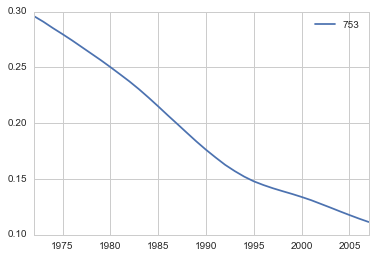

In [12]:
# remove NaN days
series3_nona = series3_data.dropna()

# Plot the series over time
print series3_nona.plot()

## AR model
MA, ARMA, and ARIMA models were unsuccessful

In [13]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

In [14]:
series3_nona.describe()

,753
count,36.000000
mean,0.191769
std,0.060006
min,0.111500
25%,0.138475
50%,0.179900
75%,0.245500
max,0.296000


                              ARMA Model Results                              
Dep. Variable:                    753   No. Observations:                   36
Model:                     ARMA(1, 0)   Log Likelihood                 132.912
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sun, 02 Oct 2016   AIC                           -259.825
Time:                        10:16:25   BIC                           -255.074
Sample:                    01-01-1972   HQIC                          -258.167
                         - 01-01-2007                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2034      0.089      2.283      0.029         0.029     0.378
ar.L1.753      0.9981      0.003    370.837      0.000         0.993     1.003
                                    Roots           

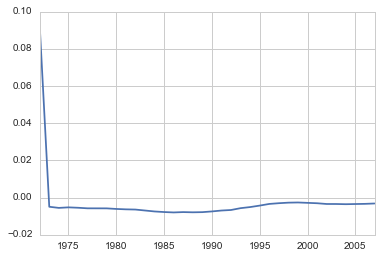

In [15]:
#compare AR, MA, ARMA, and ARIMA
model = sm.tsa.ARIMA(series3_nona, (1, 0, 0)).fit()
#unable to get MA, ARMA, or ARIMA to work- problem with dtype?
print model.summary()
print model.resid.plot()

Axes(0.125,0.125;0.775x0.775)


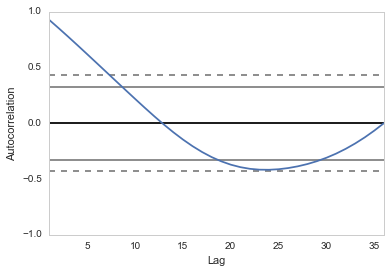

In [16]:
#check autocorr
print autocorrelation_plot(series3_nona)

## Forecasting


In [17]:
#train/test split

n = len(series3_nona)

train = series3_nona[:int(.80*n)]
test = series3_nona[int(.80*n):]

test

,753
2000-01-01,0.1339
2001-01-01,0.1310
2002-01-01,0.1277
2003-01-01,0.1244
2004-01-01,0.1210
2005-01-01,0.1177
2006-01-01,0.1145
2007-01-01,0.1115


In [18]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [19]:
#predictions
predmodel = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

predictions = predmodel.predict(
    '2000-01-01',
    '2007-01-01',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
predmodel.summary()

('Mean absolute error: ', 0.014985579892623115)


C:\Users\Heather\Anaconda\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    753   No. Observations:                   28
Model:                     ARMA(1, 0)   Log Likelihood                 100.425
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sun, 02 Oct 2016   AIC                           -194.850
Time:                        10:16:51   BIC                           -190.854
Sample:                    01-01-1972   HQIC                          -193.629
                         - 01-01-1999                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2161      0.076      2.832      0.009         0.067     0.366
ar.L1.753      0.9969      0.004    227.701      0.000         0.988     1.005
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0031           +0.0000j            1.0031            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
#forecast 2008 and 2012 (out of sample forecast)
predictions812 = predmodel.forecast(
    steps=5, exog=None, alpha=0.05
)
#check above parameters
print predictions812
#export to submission file

(array([ 0.13684578,  0.13709081,  0.13733507,  0.13757858,  0.13782134]), array([ 0.00611872,  0.00863981,  0.01056524,  0.01218088,  0.01359767]), array([[ 0.12485331,  0.14883826],
       [ 0.12015708,  0.15402453],
       [ 0.11662758,  0.15804256],
       [ 0.11370449,  0.16145267],
       [ 0.11117039,  0.16447228]]))


## Next steps
Create algorithm to perform analysis on all prediction variables to forecast 2008 and 2012.

(see Pipeline notebook)